In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl
from scipy.linalg import sqrtm

In [2]:
plt.rcParams.update({'font.size': 15})

## The plotting handler

In [3]:
def plot_with_errorband(ax,trial_data,indices = None,label='',stepped=False):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    if stepped:
        mu = np.repeat(mu,2)[1:]
        std = np.repeat(std,2)[1:]
        indices = np.repeat(indices,2)[:-1]
   
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [4]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

In [5]:
def expected_cost(M):
    x_dim = M.shape[-1]
    u_dim = M.shape[-2]

    # A_pow[n] = A^n, A_pow[0:H]
    AK_pow = [np.eye(x_dim)]
    for i in range(H):
        AK_pow.append(AK_pow[-1].dot(AK))

    # Express Transition Kernel Phi
    Phi = []

    for k in range(2*H):
        if k<H:
            Phi_k = AK_pow[k]
        else:
            Phi_k = 0

        for i in range(H):
            if 0<= k-i-1 and k-i-1<H:
                Phi_k += AK_pow[i].dot(B).dot(M[k-i-1])
        Phi.append(Phi_k)


    R_sqrt = sqrtm(R)
    Q_sqrt = sqrtm(Q)
    w_sqrt = sqrtm(w_cov)

    R_loss = np.sum(
        [np.linalg.norm(R_sqrt.dot( (M[k]-K_stab).dot(Phi[k]) ).dot(w_sqrt),'fro')**2 for k in range(H)]\
        +[np.linalg.norm(R_sqrt.dot( K_stab.dot(Phi[k]) ).dot(w_sqrt),'fro')**2 for k in range(H,2*H)])

    # The Q loss
    Q_loss = np.sum([np.linalg.norm(Q_sqrt.dot(Phi[k]).dot(w_sqrt),'fro')**2 for k in range(2*H)])
    
    return R_loss+Q_loss

In [6]:
data = {}
  
with open('./data/Parameters.pkl','rb') as f:
    data['Parameters'] = pkl.load(f)

Q = data['Parameters']['Q']
R = data['Parameters']['R']
AK = data['Parameters']['AK']
K_stab = data['Parameters']['K_stab']

A = data['Parameters']['A']
B = data['Parameters']['B']
H = data['Parameters']['H']
w_cov = data['Parameters']['w_cov']


etas = data['Parameters']['eta_bars']


control_alg = ['SafeLearning_eta_{}'.format(eta) for eta in etas] + ['ConstrainedDAP']
name_to_eta ={'SafeLearning_eta_{}'.format(eta) : eta for eta in etas}

costs = {alg:[] for alg in control_alg}
expected_costs = {alg:[] for alg in control_alg}

In [7]:
for alg in control_alg:

    with open('./data/{}.pkl'.format(alg),'rb') as f:
        data[alg] = pkl.load(f)


In [8]:
data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([5., 2., 1., 2.]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([5. , 9.8]),
 'w_cov': array([[0.04, 0.  ],
        [0.  , 0.04]]),
 'alpha_limit': (0.5, 1.2),
 'beta_limit': (0.2, 0.4),
 'H': 6,
 'H_benchmark': 6,
 'eta_bars': [0.1, 0.2, 0.5, 1.0],
 'A': array([[1.  , 1.  ],
        [0.  , 0.75]]),
 'AK': array([[ 1.        ,  1.        ],
        [-0.66666667, -0.25      ]]),
 'B': array([[0.],
        [1.]]),
 'A_hat_0': array([[1. , 1. ],
        [0. , 0.6]]),
 'B_hat_0': array([[0. ],
        [0.9]]),
 'r_0': 0.2,
 'w_max': 0.2,
 'K_stab': array([[0.66666667, 1.        ]]),
 'b_target': -0.4325777165148185,
 'l': 0.25,
 'm': 1,
 'dt': 1}

## Estimation error vs t.

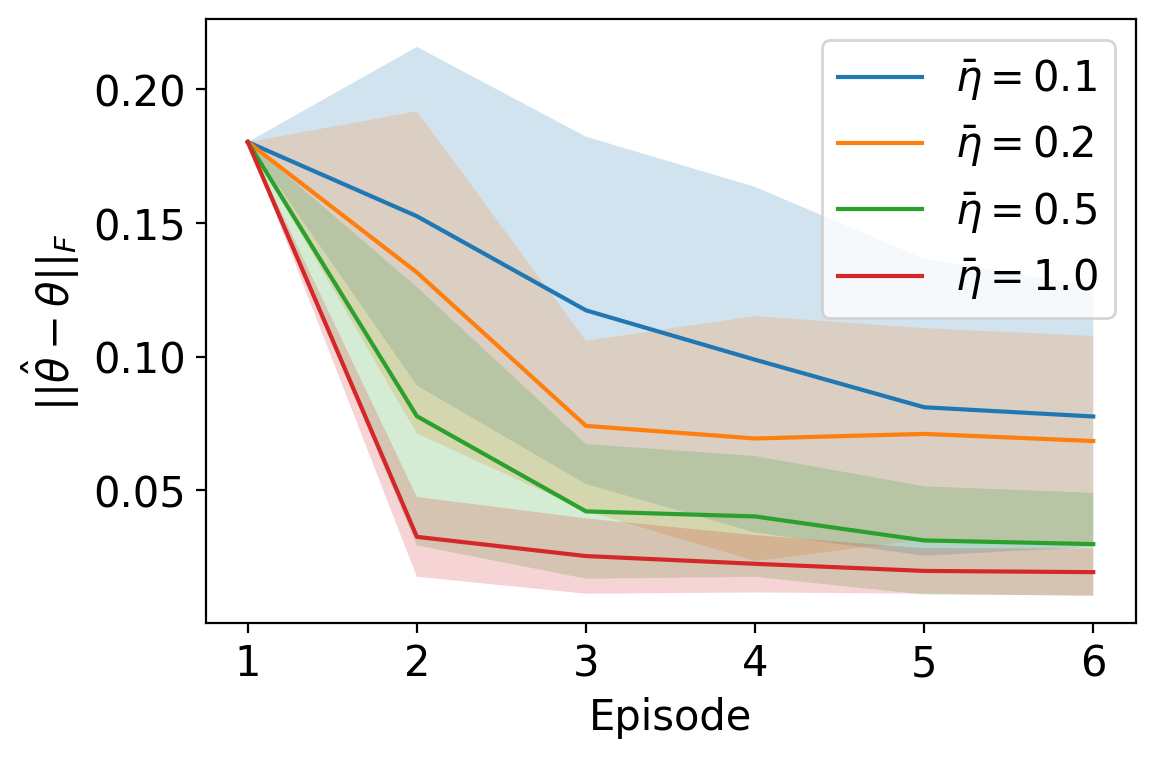

In [10]:

plt.figure(dpi=200)
ax = plt.gca()
for key,item in data.items():
    
    if key!='ConstrainedDAP' and key!='Parameters':

        
        thetas = [d['theta'] for d in item]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])
        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        A_diff = np.linalg.norm(As-A,'fro',axis=(-1,-2))
        B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
        theta_diff = np.sqrt(A_diff**2+B_diff**2)
        
        
        
        plot_with_errorband(ax,theta_diff,1+np.arange(theta_diff.shape[1],),label=r'$\bar\eta=${}'.format(name_to_eta[key]))

        ax.set_xticks(range(1,theta_diff.shape[1]+1))
        ax.set_ylabel(r'$||\hat{\theta}-\theta||_F$')
        ax.set_xlabel(r'Episode')
        ax.legend()

plt.savefig('./figures/EstimationError.png')
plt.show()